# ECG Heartbeat Categoritzation Dataset (MIT-HIB)

## Download and parse data from Kaggle

Download from https://www.kaggle.com/datasets/mondejar/mitbih-database and unzip to data/mitbih  
Sample: file structure in data/mitbih
```
mitbih
  ├── mitbih_test.csv
  ├── mitbih_train.csv
  ├── ptbdb_abnormal.csv
  └── ptbdb_normal.csv
 ```

## Setup Data

In [3]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import time
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

root_folder = Path(input("Enter the folder path: (leave blank for default)")) # leave blank for default
assert root_folder.exists(), "The folder does not exist"
assert (root_folder / "data/mitbih/mitbih_test.csv").exists(), "The folder does not exist"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/home/rain/anaconda3/envs/cos597a/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/rain/anaconda3/envs/cos597a/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Load train and test data

In [4]:
train_df = pd.read_csv(root_folder / 'data/mitbih/mitbih_train.csv', header = None).astype(np.float32)
test_df = pd.read_csv(root_folder / 'data/mitbih/mitbih_test.csv', header = None).astype(np.float32)

train_data = train_df.to_numpy()
test_data = test_df.to_numpy()

train_x, train_y = train_data[:, :-1], train_data[:, -1].astype(int)
test_x, test_y = test_data[:, :-1], test_data[:, -1].astype(int)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((87554, 187), (87554,), (21892, 187), (21892,))

### Visualization Samples

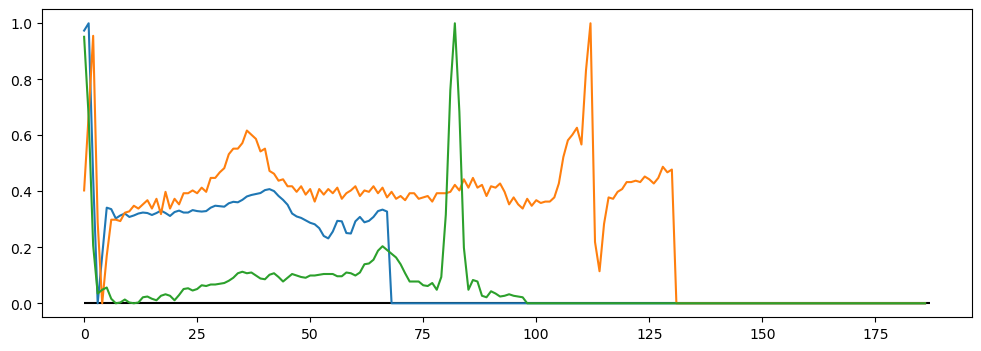

In [64]:
plt.figure(figsize=(12, 4))
plt.hlines(0, 0, len(test_x[0]), colors='black', linestyles='solid')
plt.plot(range(len(test_x[00])), test_x[30])
plt.plot(range(len(test_x[00])), test_x[234])
plt.plot(range(len(test_x[00])), test_x[1200])

## Pinecone

In [34]:
import os
import pinecone
import json

try:
    pinecone_config = json.load(open(root_folder / 'pinecone.config.json'))
except FileNotFoundError as e:
    print("Pinecone.json not found. Please copy ./pinecone-template.config.json and fill in the values.")
    raise e

# get api key from app.pinecone.io
PINECONE_API_KEY = os.environ.get('PINECONE_API_KEY') or pinecone_config['PINECONE_API_KEY']
# find your environment next to the api key in pinecone console
PINECONE_ENV = os.environ.get('PINECONE_ENVIRONMENT') or pinecone_config['PINECONE_ENVIRONMENT']

pinecone.init(
    api_key=PINECONE_API_KEY,
    environment=PINECONE_ENV
)

/home/rain/anaconda3/envs/cos597a/lib/python3.10/site-packages/pinecone/index.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


### Get or create an index

In [35]:
def get_pinecone_index(index_name, metric="cosine"):
    assert metric in ['cosine', 'euclidean', 'dotproduct']
    # only create index if it doesn't exist
    new_index = False
    if index_name not in pinecone.list_indexes():
        pinecone.create_index(
            name=index_name,
            dimension=train_x.shape[1],
            metric=metric
        )
        # wait a moment for the index to be fully initialized
        time.sleep(1)
        new_index = True


    # now connect to the index
    index = pinecone.GRPCIndex(index_name)
    return index, new_index

index_name = 'mit-bih-c'
index, new_index = get_pinecone_index(index_name, 'cosine')
index, new_index

(<pinecone.core.grpc.index_grpc.GRPCIndex at 0x7f0cd2d95240>, False)

### Upload vectors if new index

In [10]:
def upload_vector(train_x, train_y):
    print(len(train_x), len(train_y))

    temp = {'id': [], 'embeddings': [], 'metadata': []}
    for i in range(train_x.shape[0]):
        temp['id'].append(i)
        temp['embeddings'].append(train_x[i])
        tempdict = dict()
        tempdict['label'] = str(train_y[i])
        temp['metadata'].append(tempdict)
        
    train_df_vec = pd.DataFrame.from_dict(temp)

    def chunker(seq, size):
        'Yields a series of slices of the original iterable, up to the limit of what size is.'
        for pos in range(0, len(seq), size):
            yield seq.iloc[pos:pos + size]

    def convert_data(chunk):
        'Converts a pandas dataframe to be a simple list of tuples, formatted how the `upsert()` method in the Pinecone Python client expects.'
        data = []
        for i in chunk.to_dict('records'):
            if 'metadata' in i:
                data.append((str(i['id']),i['embeddings'],i['metadata']))
            else:
                data.append((str(i['id']),i['embeddings']))
        return data


    for chunk in chunker(train_df_vec, 100):
        index.upsert(vectors=convert_data(chunk))

if new_index:
    upload_vector(train_x, train_y)

### Run Test

In [13]:

from collections import defaultdict
import json

def run_test(index, test_x, test_y, file='total_results'):

    def query(res):
        label_count = defaultdict(int)
        for match in res['matches']:
            label_count[match.metadata['label']] += 1
        
        max_count = max(label_count.values())  # Find the maximum count value
        max_keys = [key for key, count in label_count.items() if count == max_count]  # Find all keys with the max count

        return label_count, max_keys, res['matches'][0].metadata['label']

    total, top1, correct = 0, 0, 0
    total_results = []
    total_query = []

    matrix = {}
    for k in set(test_y):
        matrix[str(k)] = {}
        for j in set(test_y):
            matrix[str(k)][str(j)] = 0
            
    for i, test_1 in enumerate(test_x):
        res = index.query(
            vector=test_1,
            top_k=10,
            include_metadata=True
        )
        label = str(test_y[i])
        total_results.append((label, res.to_dict()['matches']))
        if len(res['matches']) == 10:
            total += 1
            q = query(res)
            total_query.append(q)
            # print(i, label, q[1:])
            matrix[label][str(q[2])] += 1
            if str(q[2]) == label:
                top1 += 1
            if str(q[1][0]) == label:
                correct += 1

    print(f'Total results: {total}')
    print(f"Top1: {top1}")
    print(f"Correct: {correct}")
    print(f"Top 1 Accuracy: {top1 / total * 100:.6f}%")
    print(f"Top 10 Accuracy: {correct / total * 100:.6f}%")
    json.dump(total_results, open(root_folder / (file + ".json"), 'w'))
    return (total, top1, correct), (top1 / total * 100, correct / total * 100), matrix


index, _ = get_pinecone_index("mit-bih-c")
res, acc, matrix = run_test(index, test_x, test_y, file='total_results')

Total results: 21892
Top1: 21386
Correct: 21300
Top 1 Accuracy: 97.688653%
Top 10 Accuracy: 97.295816%


### Plot Confusion Matrix

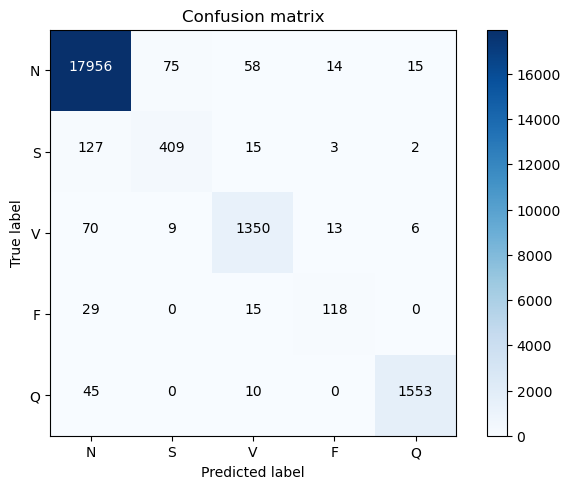

In [16]:
import itertools

# Extracting labels and counts
label_index = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
labels = label_index.keys()
confusion_matrix = np.array([[matrix[str(label_index[row])][str(label_index[col])] for col in labels] for row in labels])

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_matrix, classes=labels)
plt.show()

## Connect to Apple Health Database

1. In Apple Health app, click profile icon and scroll down to the end.
2. Click "Export All Health Data" button and copy the `export.zip` to `data/` folder
3. Unzip it  

Sample data folder:
```
apple_health_export
├── electrocardiograms
│   ├── ecg_2021-10-15_1.csv
│   ├── ecg_2021-10-15_2.csv
│   ├── ................
│   └── ecg_2022-10-23.csv
├── export_cda.xml
├── export.xml
└── workout-routes
    ├── route_2021-10-21_6.17pm.gpx
    ├── route_2022-05-05_8.49pm.gpx
    ├── ................
    └── route_2023-11-07_5.31pm.gpx
```

In [2]:
assert (root_folder / "data/apple_health_export/electrocardiograms").exists(), "The ECG record folder does not exist"

ecg_folder = root_folder / "data/apple_health_export/electrocardiograms"
ecg_files = list(ecg_folder.glob('*.csv'))

print(f"Found {len(ecg_files)} ECG records")

Found 17 ECG records


### Analyze the last ECG record (most recent)

In [3]:
def parse_ecg(ecg_file):
    last_ecg = pd.read_csv(ecg_file, header=None)
    test_x = last_ecg[10:].to_numpy().astype(np.float32)[:,0]
    profile = {
        "name": last_ecg.iloc[0][1],
        "birthday": last_ecg.iloc[1][1],
        "date": last_ecg.iloc[2][1],
        "class": last_ecg.iloc[3][1],
        "symptoms": last_ecg.iloc[4][1],
        "version": last_ecg.iloc[5][1],
        "device": last_ecg.iloc[6][1],
        "sample_rate": int(last_ecg.iloc[7][1].split(" ")[0]),
        "lead": last_ecg.iloc[8][1],
        "unit": last_ecg.iloc[9][1],
    }
    print(profile)
    return test_x, profile

test_apple, profile = parse_ecg(sorted(ecg_files)[-1])

{'name': 'Yucan Wu', 'birthday': 'Dec 9, 1998', 'date': '2022-10-23 16:42:01 -0500', 'class': 'Sinus Rhythm', 'symptoms': nan, 'version': '1.90', 'device': 'Watch6,7', 'sample_rate': 512, 'lead': 'Lead I', 'unit': 'µV'}


### Visualize the data

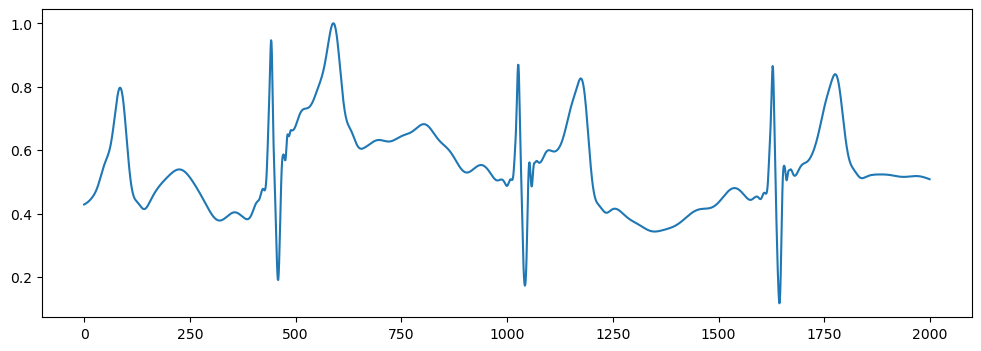

In [4]:
norm_test_apple = (test_apple - test_apple.min()) / (test_apple.max() - test_apple.min())
plt.figure(figsize=(12, 4))
plt.plot(norm_test_apple[:2000])

In [37]:
from biosppy.signals import ecg
from scipy.signal import resample

def split_beat(signal, input_fs=512, output_fs=125, pad=60, padding_size=187):
    out = ecg.ecg(signal=signal, sampling_rate=profile['sample_rate'], show=False)
    rpeaks = np.zeros_like(signal, dtype='float')
    rpeaks[out['rpeaks']] = 1.0

    # Split into individual heartbeats. For each heartbeat
    # record, append classification (normal/abnormal).
    beats = np.split(signal, out['rpeaks'])
    final_beats = []
    for idx, idxval in enumerate(out['rpeaks']):
        firstround = idx == 0
        lastround = idx == len(beats) - 1

        # Skip first and last beat.
        if (firstround or lastround):
            continue

        # Append some extra readings from next beat.
        beats[idx] = np.append(beats[idx], beats[idx+1][:pad])

        # Normalize the readings to a 0-1 range for ML purposes.
        beats[idx] = (beats[idx] - beats[idx].min()) / beats[idx].ptp()

        # Resample from 360Hz to 125Hz
        newsize = int((beats[idx].size * output_fs / input_fs) + 0.5)
        beats[idx] = resample(beats[idx], newsize)

        # Skipping records that are too long.
        if (beats[idx].size > 187 + pad):
            continue
        elif (beats[idx].size > 187):
            beats[idx] = beats[idx][:187]

        # Pad with zeroes.
        zerocount = padding_size - beats[idx].size
        beats[idx] = np.pad(beats[idx], (0, zerocount), 'constant', constant_values=(0.0, 0.0))
        final_beats.append(beats[idx])
        
    return np.array(final_beats)

beats = split_beat(test_apple, pad=58)

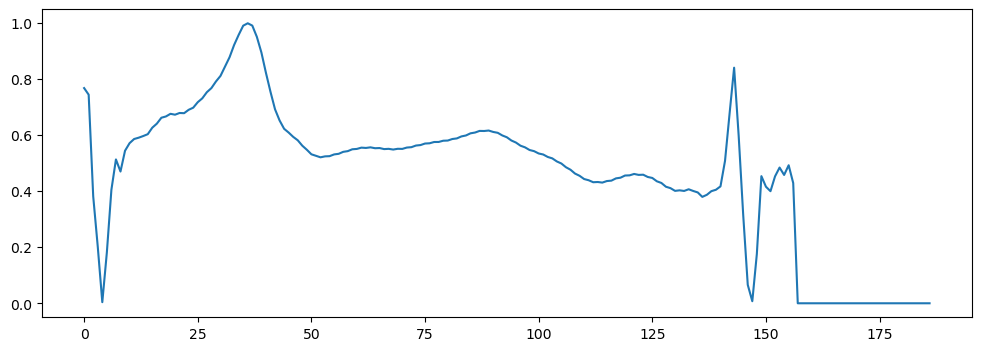

In [39]:
# norm_test_apple = (test_apple - test_apple.min()) / (test_apple.max() - test_apple.min())
plt.figure(figsize=(12, 4))
plt.plot(beats[0])

In [8]:
res = index.query(
    vector=beats[0],
    top_k=10,
    include_metadata=True
)
res[0][1][0].metadata['label']

NameError: name 'index' is not defined

In [5]:
import json
past_res = json.load(open(root_folder / 'total_results.json'))

In [7]:
past_res[0][1]

[{'id': '22389',
  'score': 0.9956253,
  'values': [],
  'sparse_values': {'indices': [], 'values': []},
  'metadata': {'label': '0'}},
 {'id': '28521',
  'score': 0.99542385,
  'values': [],
  'sparse_values': {'indices': [], 'values': []},
  'metadata': {'label': '0'}},
 {'id': '30472',
  'score': 0.9950652,
  'values': [],
  'sparse_values': {'indices': [], 'values': []},
  'metadata': {'label': '0'}},
 {'id': '41825',
  'score': 0.9948355,
  'values': [],
  'sparse_values': {'indices': [], 'values': []},
  'metadata': {'label': '0'}},
 {'id': '43704',
  'score': 0.99475235,
  'values': [],
  'sparse_values': {'indices': [], 'values': []},
  'metadata': {'label': '0'}},
 {'id': '44800',
  'score': 0.99464625,
  'values': [],
  'sparse_values': {'indices': [], 'values': []},
  'metadata': {'label': '0'}},
 {'id': '2039',
  'score': 0.9941571,
  'values': [],
  'sparse_values': {'indices': [], 'values': []},
  'metadata': {'label': '0'}},
 {'id': '37228',
  'score': 0.9938334,
  'valu

In [41]:
res

{'matches': [{'id': '19845',
              'metadata': {'label': '0'},
              'score': 0.9756271,
              'sparse_values': {'indices': [], 'values': []},
              'values': []},
             {'id': '20452',
              'metadata': {'label': '0'},
              'score': 0.974708,
              'sparse_values': {'indices': [], 'values': []},
              'values': []},
             {'id': '49457',
              'metadata': {'label': '0'},
              'score': 0.97342557,
              'sparse_values': {'indices': [], 'values': []},
              'values': []},
             {'id': '54929',
              'metadata': {'label': '0'},
              'score': 0.9731472,
              'sparse_values': {'indices': [], 'values': []},
              'values': []},
             {'id': '46078',
              'metadata': {'label': '0'},
              'score': 0.9730962,
              'sparse_values': {'indices': [], 'values': []},
              'values': []},
             {'id': 